## Gael Blanchard
###  Problem: Given the Global Terrorism Data Set construct a predictive model which can determine which terrorist group is responsible for an event

## Global Terrorism Data
[Source: National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2016). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd](http://www.start.umd.edu/gtd)

In [101]:
#Required Libraries
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.metrics import accuracy_score, hamming_loss
import matplotlib.pyplot as plt

In [102]:
#Disables SettingWithCopy Warning
pd.options.mode.chained_assignment = None
#Set the random seed for reproducible results
np.random.seed(0)

# 1.   Data Collection
* Read in our data from the Global Terrorism Database into a Pandas Data Frame
* Isolated the variables we needed (10/135 available)

In [103]:
#Isolated features for use in our classification models
#at Data Collection stage to lower memory usage
global_terrorism_data = pd.read_excel("globalterrorismdb_0617dist.xlsx")

In [104]:
#Prelimanary Feature Selection
#determine our most complete data sets
column_names = global_terrorism_data.columns.values
missing_data = global_terrorism_data.isna().any()
value = 0
for data in missing_data:
    if not data:
        print(data," ",column_names[value])
        value = value + 1
    else:
        print(data," ",column_names[value])
        value = value + 1


False   eventid
False   iyear
False   imonth
False   iday
True   approxdate
False   extended
True   resolution
False   country
False   country_txt
False   region
False   region_txt
True   provstate
True   city
True   latitude
True   longitude
True   specificity
False   vicinity
True   location
True   summary
False   crit1
False   crit2
False   crit3
False   doubtterr
True   alternative
True   alternative_txt
False   multiple
False   success
False   suicide
False   attacktype1
False   attacktype1_txt
True   attacktype2
True   attacktype2_txt
True   attacktype3
True   attacktype3_txt
False   targtype1
False   targtype1_txt
True   targsubtype1
True   targsubtype1_txt
True   corp1
True   target1
True   natlty1
True   natlty1_txt
True   targtype2
True   targtype2_txt
True   targsubtype2
True   targsubtype2_txt
True   corp2
True   target2
True   natlty2
True   natlty2_txt
True   targtype3
True   targtype3_txt
True   targsubtype3
True   targsubtype3_txt
True   corp3
True   target3
True   natl

To classify a terrorist incident we want to gather the most complete and desciptive features within our data. We want to answer who(targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname.gname2,gsubname2,gname3,gsubname3,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propcomment,ishostkid,nhostkid,nhostkidus,addnotes), what(eventid,resolution,summary,doubterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3_txt,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,hostkidoutcome,hostkidoutcome_txt,nreleased,INT_IDEO,INT_MISC,INT_ANY), when (iyear,imonth,iday,approxdate,extended,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote), where(country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,divert,kidhijcountry), why(crit1,crit2,crit3,motive) and how(weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,INT_LOG,INT_IDEO).
We ignore all other variables (scite1,scite2,scite3,dbsource)

In [105]:
factors_list = ["gname","eventid","extended","provstate","iyear","country","attacktype1","targtype1","weaptype1","multiple","success","suicide","city"]
viz_factors_list = ["gname","iyear","extended","country_txt","attacktype1_txt","targtype1_txt","weaptype1_txt","multiple","success","suicide","city"]

In [106]:
#Describe the data we have just read in
gt_data_for_viz = global_terrorism_data[viz_factors_list]
global_terrorism_data = global_terrorism_data[factors_list]
gt_data_for_viz.describe(include="all")

,gname,iyear,extended,country_txt,attacktype1_txt,targtype1_txt,weaptype1_txt,multiple,success,suicide,city
count,170350,170350.000000,170350.000000,170350,170350,170350,170350,170350.000000,170350.000000,170350.000000,169904
unique,3454,NaN,NaN,205,9,22,12,NaN,NaN,NaN,33957
top,Unknown,NaN,NaN,Iraq,Bombing/Explosion,Private Citizens & Property,Explosives/Bombs/Dynamite,NaN,NaN,NaN,Unknown
freq,78306,NaN,NaN,22130,83073,39994,86704,NaN,NaN,NaN,9162
mean,NaN,2001.709997,0.043634,NaN,NaN,NaN,NaN,0.134206,0.896396,0.033871,NaN
std,NaN,13.144146,0.204279,NaN,NaN,NaN,NaN,0.340875,0.304747,0.180899,NaN
min,NaN,1970.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,NaN,1990.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN
50%,NaN,2007.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN
75%,NaN,2014.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN


# Features Selected for our predictive models:
* **Gname/Perpetrator Group Name:** We see that there are 3,454 unique values for gname and is non-numerical. We will have to factorize for classification models. "Unknown" is the top perpetrator group within the data which presents a problem.
* **Iyear/ Year of Incident:** This is numerical data and spand from 1970 to 2016
* **Vicinity:** Dichotomous variable that indicates whether an event occured in the city or in the vicinity of the city
* **Country_txt/ Country Name:** There are 205 differnt countries within the dataset. Iraq has the most recorded Terrorist Incidents
* **Attacktype1_txt/ Type of Terrorist Attack:** There are 9 categories of Attack Types with "Bombing/Explosion" being the most prevalent in Terrorist Incidents
* **Targtype1_txt/ Type of Target of Terrorist Attack:** There are 22 categories of Target Types with "Private Citizens & Property" being the most prevalent in Terrorist Incidents
* **Weaptype1_txt/ Primary type of Weapon used in Terrorist Attack:** There are 12 categories of Weapon Types with "Explosives/Bombs/Dynamite" being the most frequent. This goes hand in hand with AttackType1_txt
* **Multiple:** This is a dichotomous variable determines if a terrorist incident is related to several incidents or not. We can tell that the majority of incidents are classified as not related
* **Success:** This is a dichotomous variable that determines if a terrorist incident was successful. A majority of these attacks are indeed successful.
* **Suicide:** This is a dichotomous variable that determines if a terrorist incident was a suicide attack or not. A majority of terrorist incidents are not classified as suicide attacks.
* **City/ City Name:** There are 33,957 different cities within the dataset. Unknown has the most recorded Terrorist Incidents. This presents a problem we can somewhat remedy with imputation.


[This website](http://www.start.umd.edu/gtd/downloads/Codebook.pdf) provides a detail explanation of all the features in the GTD. Given the explanation within the booklet, we can isolate certain features. For example, when considering a variable for time year is the most complete whereas month and day can have 0 values when unknown. This booklet also allowed the omission of feature engineering for variables such as country_txt, attacktype1_txt, targtype1_txt, and weaptype1_txt because it has associated numerical codes which serve as factors within this program.

 Logic behind selecting these features:
*  Minimal imputation (All of our features with the exception of city are complete for all rows)
* Complete features within our data allow for logical subsets within the data which is optimal for prediciton
* Prevent overfitting


# 2. Data Preparation & Exploration
* Searched for NA data within our data
* Determined the frequency of every variable besides year
* Factorized city and gname variables for usage in our predictive models
* Seperated data into known and unknown perpetrators
* Defined our train and test sets

In [107]:
#method to return the head and tail frequencies
def frequency_data(data,factors):
    for factor in factors:
        print(factor)
        print(data[factor].value_counts().head())
        #print(data[factor].value_counts().tail())

In [108]:
#Look for missing data
missing_data = global_terrorism_data.isna().any()
print(missing_data)
#Recognize that our city variable has null values
#All of our data is categorical in nature
freq_factors = ["gname","country","attacktype1","targtype1","weaptype1","multiple","success","suicide","city"]
#Frequency
frequency_data(global_terrorism_data,freq_factors)

gname          False
eventid        False
extended       False
provstate       True
iyear          False
country        False
attacktype1    False
targtype1      False
weaptype1      False
multiple       False
success        False
suicide        False
city            True
dtype: bool
gname
Unknown                                             78306
Taliban                                              6575
Shining Path (SL)                                    4551
Islamic State of Iraq and the Levant (ISIL)          4287
Farabundo Marti National Liberation Front (FMLN)     3351
Name: gname, dtype: int64
country
95     22130
153    13634
4      11306
92     10978
45      8163
Name: country, dtype: int64
attacktype1
3    83073
2    40223
1    18402
6    10233
7     9581
Name: attacktype1, dtype: int64
targtype1
14    39994
4     25508
3     22938
2     20314
1     19873
Name: targtype1, dtype: int64
weaptype1
6     86704
5     55273
13    13852
8     10459
9      3338
Name: weaptype1, dtype:

Note: There are several classes with single instances

In [109]:
#Imputations on ProvState
#Must impute provstate befroe city because citys imputation is reliant on the provstate
global_terrorism_data["provstate"] = np.where(global_terrorism_data["provstate"].isnull(),
                                              "Unknown",global_terrorism_data["provstate"])
#We have to confirm that all entries in the data is not null
missing_data = global_terrorism_data["provstate"].isna().any()
print(missing_data)


False


In [110]:
#Imputations on City
#Where city is unknown replace with provstate
global_terrorism_data["city"] = np.where(global_terrorism_data["city"] == "Unknown",
                                              global_terrorism_data["provstate"],
                                         global_terrorism_data["city"])
#Make sure that there is no null values within the city
global_terrorism_data["city"] = np.where(global_terrorism_data["city"].isnull(),
                                              "Unknown",
                                         global_terrorism_data["city"])
missing_data = global_terrorism_data["city"].isna().any()
print(missing_data)

False


In [111]:
#We also factorize our variable to predict (Perpetrator Group Name)
#Factorizing data will remove the missing data and seperate city into classes
global_terrorism_data["citynumber"] = pd.factorize(global_terrorism_data["city"])[0]
global_terrorism_data["gnumber"] = pd.factorize(global_terrorism_data["gname"])[0]

In [112]:
#Training and Test Data Sets for Classes as they appear within our data
training_data = global_terrorism_data
test_data = global_terrorism_data.sample(frac=0.8, replace=False)
test_unknown = global_terrorism_data[global_terrorism_data["gnumber"] == 2]
#list of factors to use for prediction
predictor_factors = ["iyear","country","extended","attacktype1","targtype1","weaptype1","multiple","success","suicide","citynumber"]

In [113]:
#Confirm that the data is only "Unknown" classification
test_unknown.head()

,gname,eventid,extended,provstate,iyear,country,attacktype1,targtype1,weaptype1,multiple,success,suicide,city,citynumber,gnumber
2,Unknown,197001000001,0,Tarlac,1970,160,1,10,13,0,1,0,Tarlac,2,2
3,Unknown,197001000002,0,Attica,1970,78,3,7,6,0,1,0,Athens,3,2
4,Unknown,197001000003,0,Unknown,1970,101,7,7,8,0,1,0,Fukouka,4,2
7,Unknown,197001020002,0,California,1970,217,3,21,6,0,1,0,Oakland,7,2
12,Unknown,197001080001,0,Lazio,1970,98,4,6,5,0,1,0,Rome,11,2


## Data Visulaizations

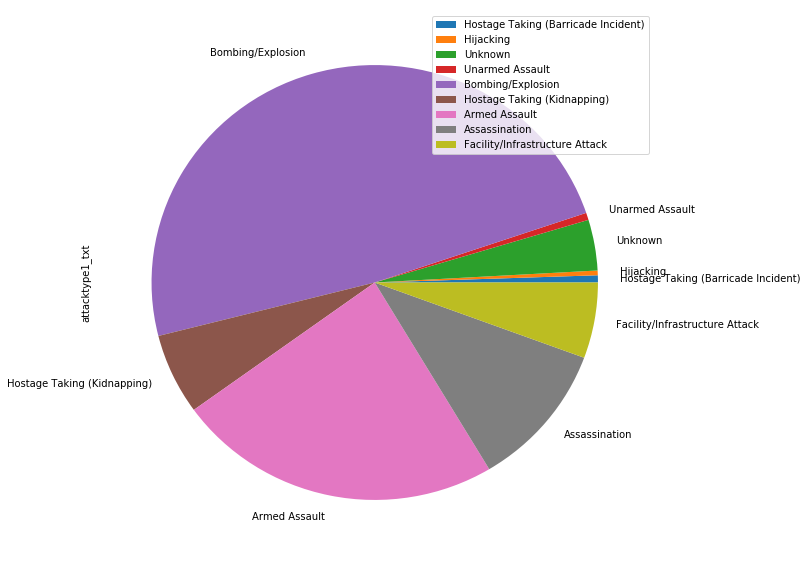

In [114]:
#AttackType
gt_data_for_viz["attacktype1_txt"].value_counts(sort=False).plot.pie(figsize=(10, 10),fontsize=10,legend="true")
plt.show()

Attack Type is a reliable feature as there is more classified data then unknown data.

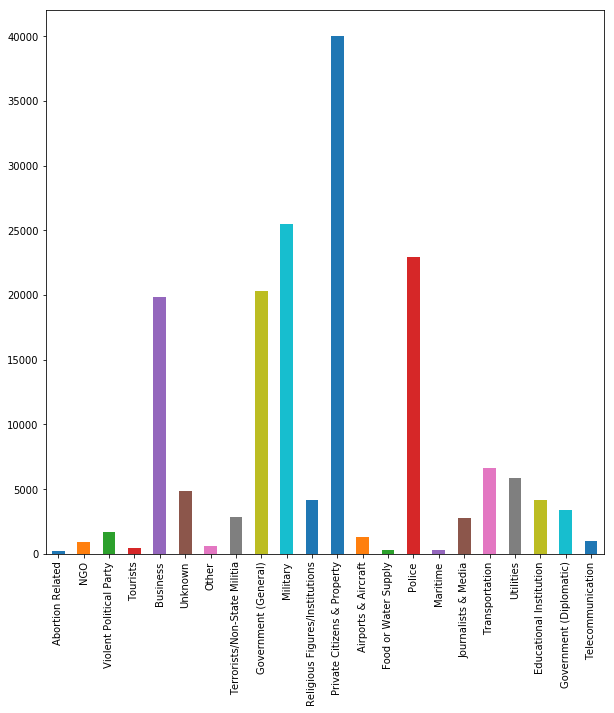

In [115]:
#Targ Type
gt_data_for_viz["targtype1_txt"].value_counts(sort=False).plot(kind="bar",figsize=(10, 10))
plt.show()

Target Type is reliable as a feature in the data because there is more recorded data then unknown data.

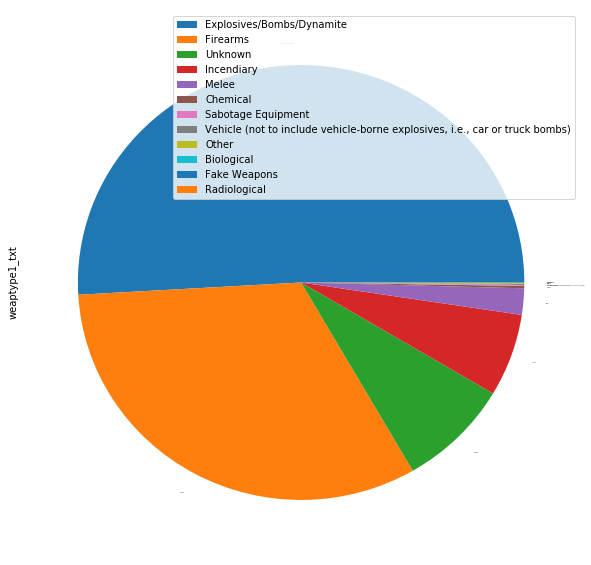

In [116]:
#Weapon Type
gt_data_for_viz["weaptype1_txt"].value_counts(sort=True).plot.pie(figsize=(10, 10),fontsize=0,legend="true")
plt.show()

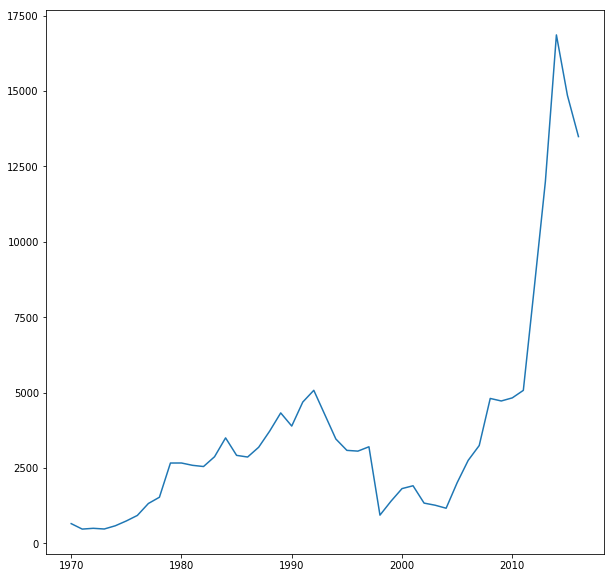

In [117]:
#Recorded Terrorist Incidents per year
gt_data_for_viz["iyear"].value_counts().sort_index().plot(figsize=(10, 10))
plt.show()

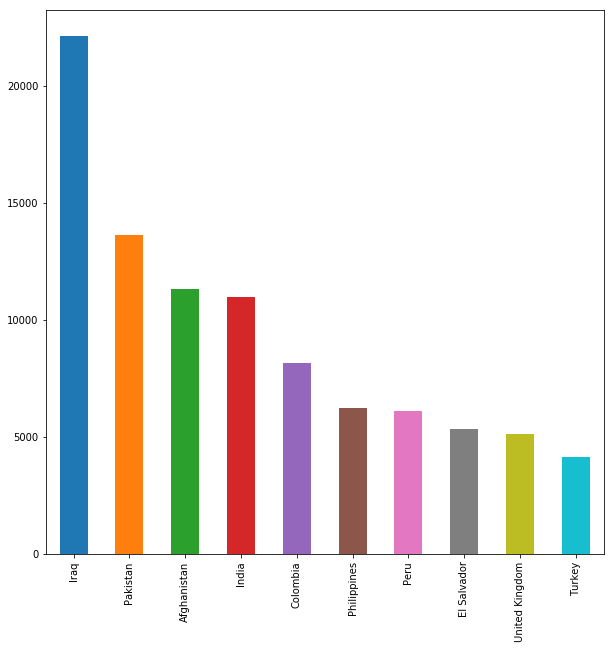

In [118]:
#Top 10 Recorded Terrorist Incidents per country
gt_data_for_viz["country_txt"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

Country is a reliable feature in the data as it has many classes and various data points for each(if not every) class

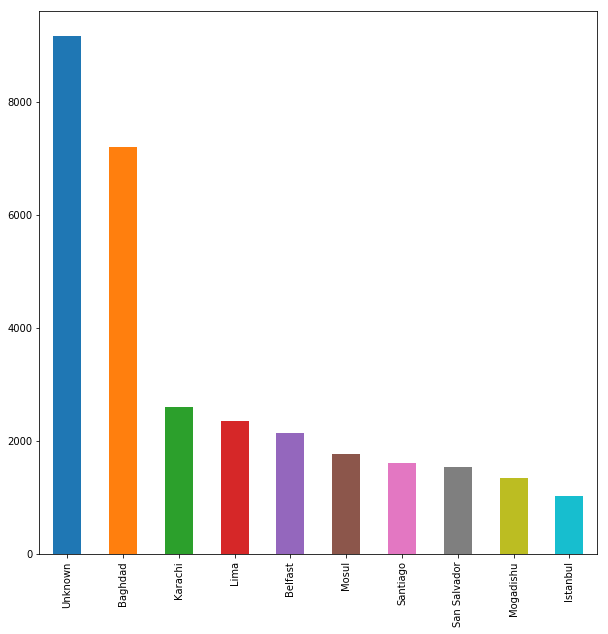

In [119]:
#Top 10 recorded terrorist incidents per city (pre imputation)
gt_data_for_viz["city"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

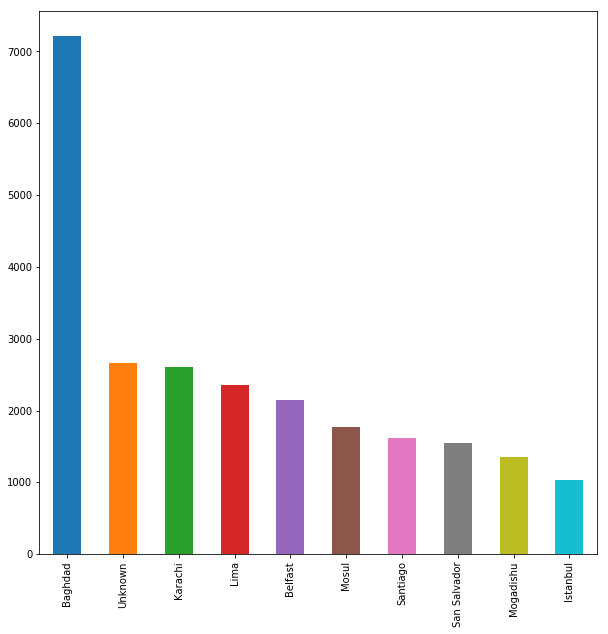

In [120]:
#Top 10 Recorded Terrorist Incidents per city (after imputation)
global_terrorism_data["city"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

Note: The amount of terrorist incidents with the "Unknown" classification have reduced dramatically given imputation. Post imputation city becomes a far more reliable feature of data for use with prediction.

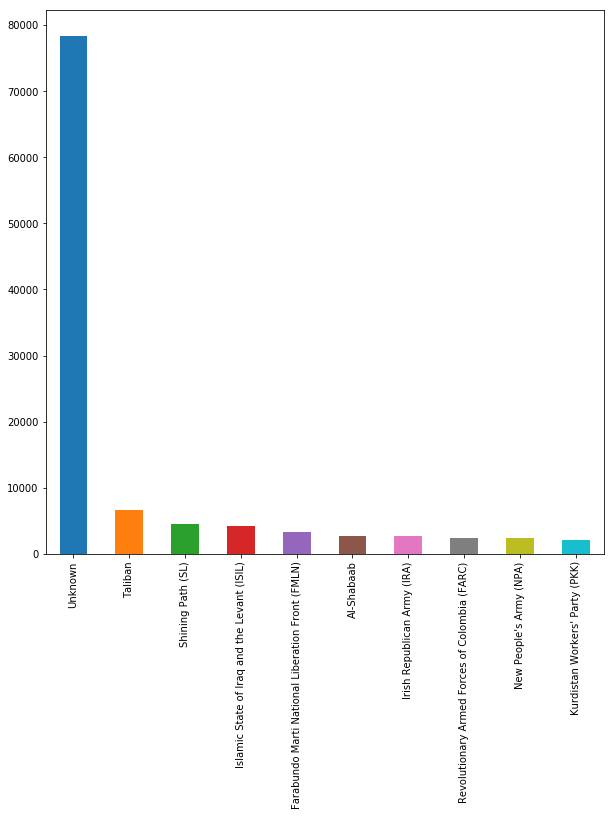

In [121]:
#Top 10 Perpetrator Groups by incidents
gt_data_for_viz["gname"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

A majority of the perpetrators are classified as "Unknown". Our task is to be able to classify this majority into other perpetrator groups

Note: With these visualizations, notice how features in the data can partition the data into smaller and unique subsets

# 3. Training ,Testing and Evaluating Algorithms 
*  Applying our method just to ascertain how accurate we can make our classification models
*  Initialized classifcation models (Decision Tree, KNN and Random Forest)
*  Trained classification models
*  Evaluated our classification models

In [122]:
#Initialize Classifier Models
#Decision Tree, KNN, Random Forest
dtree_model = DecisionTreeClassifier(max_depth = 100)
knn_model = KNeighborsClassifier(n_neighbors=1)

## Why Decision Tree?
DT is a classification model which performs implicit feature selection and is not affected by non-linear relationships within the data. DTs create a set of rules based on the features of the data which is then used to determine the class of a test data point. Chose DT over random forest classification implementation because random forest is computationally expensive with our training data set.

In [123]:
#Training Algorithms
dtree_model.fit(training_data[predictor_factors],training_data["gnumber"])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Why K-Nearest Neighbors?
KNN is a simple classification model that is highly dependent on the similarity between a test data point and a stored data point(the neighbor(s)) from the training data used in the model. There are multiple single class instances within our GTD dataset(e.g., One time terrorist groups, City's that have been attacked once, etc.). By setting the algorithm to classify the test data points based on the single most similar neighbor we should be able to classify those instances with high accuracy.

In [124]:
knn_model.fit(training_data[predictor_factors],training_data["gnumber"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [125]:
#decision tree test
dtree_predictions = dtree_model.predict(test_data[predictor_factors])

In [126]:
#Test Unknown
dtree_unknown = dtree_model.predict(test_unknown[predictor_factors])

In [127]:
#KNN test
knn_pred = knn_model.predict(test_data[predictor_factors])

In [128]:
#KNN Unknown
knn_unknown = knn_model.predict(test_unknown[predictor_factors])

## Evaluating Models
* custom function for accuracy
* accuracy score
* hamming loss

In [129]:
#Method to determine the performance of our classification models
#Does a simple comparison of predicitons and actual calculations
def print_results(predictions,data,desired_variable):
	print("Results:")
	print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
	.format(
		data.shape[0],
		(data[desired_variable] != predictions).sum(),
		100*(1-(data[desired_variable] != predictions).sum()/data.shape[0])
		)
	)

In [130]:
print("Decision Tree: ")
print_results(dtree_predictions,test_data,"gnumber")
print("Accuracy Score: ",accuracy_score(test_data["gnumber"],dtree_predictions))
print("Hamming Loss: ",hamming_loss(test_data["gnumber"],dtree_predictions))

Decision Tree: 
Results:
Number of mislabeled points out of a total 136280 points : 7636, performance 94.40%
Accuracy Score:  0.943968300558
Hamming Loss:  0.0560316994423


In [131]:
print("Decision Tree Unknown: ")
print_results(dtree_unknown,test_unknown,"gnumber")
print("Accuracy Score: ",accuracy_score(test_unknown["gnumber"],dtree_unknown))
print("Hamming Loss: ",hamming_loss(test_unknown["gnumber"],dtree_unknown))

Decision Tree Unknown: 
Results:
Number of mislabeled points out of a total 78306 points : 1666, performance 97.87%
Accuracy Score:  0.978724491099
Hamming Loss:  0.021275508901


In [132]:
print("KNN: ")
print_results(knn_pred,test_data,"gnumber")
print("Accuracy Score: ",accuracy_score(test_data["gnumber"],knn_pred))
print("Hamming Loss: ",hamming_loss(test_data["gnumber"],knn_pred))

KNN: 
Results:
Number of mislabeled points out of a total 136280 points : 9533, performance 93.00%
Accuracy Score:  0.930048429704
Hamming Loss:  0.0699515702964


In [133]:
print("KNN Unknown: ")
print_results(knn_unknown,test_unknown,"gnumber")
print("Accuracy Score: ",accuracy_score(test_unknown["gnumber"],knn_unknown))
print("Hamming Loss: ",hamming_loss(test_unknown["gnumber"],knn_unknown))

KNN Unknown: 
Results:
Number of mislabeled points out of a total 78306 points : 4418, performance 94.36%
Accuracy Score:  0.943580313131
Hamming Loss:  0.0564196868695


As noted above, there are several classes with single instances. To address these instances, I refrained from using k-fold cross-validation to determine model accuracy because we would have splits that wouldn't provide an accurate representation of all classes as they appear within the data.

I used a custom function in conjunction with built-in sci-kit learn classification metrics accuracy score, f1_score and haming loss. Didn't use Jaccard Similarity Score since it is equivalent to the accuracy score.

Testing purely unknown perpetrators the predictive model performed almost identically given a data set with a different class distribution.

In conclusion, we are able to construct a fairly accurate predictive model that can determine the perpetrator group related to an incident. By selecting and engineering the right features we are able to construct a model with upwards of 92% accuracy and downwards of 8% hamming loss.

# 4. Solving Our Problem

* Using the method from Step 3 train and test our model to predict what groups are most likely related to  terrorist incident
* Purely theoretical application
* Why the application works

In [134]:
#Use new training data that uses all classes except for the "Unknown" classifier
solution_training_data = global_terrorism_data[global_terrorism_data["gnumber"] != 2]
#test_unknown is our testing data

In [135]:
#Confirm training data is not of "Unknown" classification
solution_training_data.head()

,gname,eventid,extended,provstate,iyear,country,attacktype1,targtype1,weaptype1,multiple,success,suicide,city,citynumber,gnumber
0,MANO-D,197000000001,0,Unknown,1970,58,1,14,13,0,1,0,Santo Domingo,0,0
1,23rd of September Communist League,197000000002,0,Unknown,1970,130,6,7,13,0,1,0,Mexico city,1,1
5,Black Nationalists,197001010002,0,Illinois,1970,217,2,3,5,0,1,0,Cairo,5,3
6,Tupamaros (Uruguay),197001020001,0,Montevideo,1970,218,1,3,5,0,0,0,Montevideo,6,4
8,New Year's Gang,197001020003,0,Wisconsin,1970,217,7,4,8,0,1,0,Madison,8,5


In [136]:
#Nearest Neighbors
comparison_factors = ["iyear","country","attacktype1","targtype1",
                      "weaptype1","multiple","success","suicide",
                      "citynumber", "gnumber"]
gtd_neighbors = NearestNeighbors(n_neighbors=1)
gtd_neighbors.fit(solution_training_data[predictor_factors]) 

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=1, p=2, radius=1.0)

In [137]:
#get a small sample set for comparison sake
small_test_unknown = test_unknown.sample(n=8,replace=False)

In [138]:
#returns the distances and indices of the nearest neighbors
distances, indices = gtd_neighbors.kneighbors(small_test_unknown[predictor_factors])

In [139]:
# a look at our data set
small_test_unknown

,gname,eventid,extended,provstate,iyear,country,attacktype1,targtype1,weaptype1,multiple,success,suicide,city,citynumber,gnumber
49643,Unknown,199201080007,0,Magdalena,1992,45,2,19,8,0,1,0,Santa Marta,1285,2
118421,Unknown,201307010002,0,Khyber Pakhtunkhwa,2013,153,2,3,5,0,1,0,Peshawar,619,2
73413,Unknown,200112120004,0,Kavango,2001,139,3,14,6,1,1,0,Katonodo,14957,2
83703,Unknown,200707100006,0,Diyala,2007,95,2,14,5,0,1,0,Sherween,17356,2
17659,Unknown,198301010024,0,Unknown,1983,83,9,4,13,0,1,0,El Palmar,3296,2
86415,Unknown,200804210032,0,Nineveh,2008,95,6,2,13,0,1,0,Mosul,643,2
45176,Unknown,199101230006,0,Amman,1991,102,7,7,8,0,0,0,Amman,93,2
157490,Unknown,201601170025,0,Sirnak,2016,209,3,15,6,0,1,0,Cizre,8120,2


In [140]:
for index in indices:
    print(solution_training_data.iloc[index]["gname"],
          "GNumber:",
          solution_training_data.iloc[index]["gnumber"]
         )
    print(solution_training_data.iloc[index][predictor_factors])

53776    Narco-Terrorists
Name: gname, dtype: object GNumber: 53776    1064
Name: gnumber, dtype: int64
       iyear  country  extended  attacktype1  targtype1  weaptype1  multiple  \
53776   1992       45         0            3         14          6         0   

       success  suicide  citynumber  
53776        1        0        1285  
118585    Muslim extremists
Name: gname, dtype: object GNumber: 118585    597
Name: gnumber, dtype: int64
        iyear  country  extended  attacktype1  targtype1  weaptype1  multiple  \
118585   2013      153         0            2          3          5         0   

        success  suicide  citynumber  
118585        1        0         619  
73416    Al-Aqsa Martyrs Brigade
Name: gname, dtype: object GNumber: 73416    2399
Name: gnumber, dtype: int64
       iyear  country  extended  attacktype1  targtype1  weaptype1  multiple  \
73416   2001      155         0            3         14          6         0   

       success  suicide  citynumber  
73

Note: Analyzing the input data (small_test_unknown) and it's nearest neighbor, notice that there are several feature similarities primarily the city number and country features.

In [141]:
#The implementation to solve our problem (KNN)
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(solution_training_data[predictor_factors],solution_training_data["gnumber"])
knn_class_pred = knn_classifier.predict(small_test_unknown[predictor_factors])
print(knn_class_pred)

[1064  597 2399  630  939 2683 1474 1065]


In [142]:
#The implementation to solve our problem (DTree)
dtree_classifier = DecisionTreeClassifier(max_depth = 100)
dtree_classifier.fit(solution_training_data[predictor_factors],solution_training_data["gnumber"])
dtree_class_pred = dtree_classifier.predict(small_test_unknown[predictor_factors])
print(dtree_class_pred)

[ 202  597  470 2581  235 2683 1474 1065]


In [143]:
for pred in dtree_class_pred:
    predicted_data = global_terrorism_data[global_terrorism_data["gnumber"] == pred].head()
    print(predicted_data)

                                              gname       eventid  extended  \
2778  Revolutionary Armed Forces of Colombia (FARC)  197503000008         0   
2839  Revolutionary Armed Forces of Colombia (FARC)  197503290004         0   
3441  Revolutionary Armed Forces of Colombia (FARC)  197601140001         1   
3796  Revolutionary Armed Forces of Colombia (FARC)  197605290003         0   
4104  Revolutionary Armed Forces of Colombia (FARC)  197609280001         1   

      provstate  iyear  country  attacktype1  targtype1  weaptype1  multiple  \
2778       Meta   1975       45            2         14          5         0   
2839     Boyaca   1975       45            2         14          5         0   
3441       Meta   1976       45            6          1         13         0   
3796  Santander   1976       45            2         14          5         0   
4104     Bogota   1976       45            6          1         13         0   

      success  suicide        city  citynumb

Note: Analyzing the input data (small_test_unknown) and data entries based on output (dtree_class_pred), notice that there are several feature similarities primarily the city number and country features

# 5. Conclusion

In theory, we can build accurate classifiaction models to predict which perpetrator group is responsible for a terrorist incident. However we are not able to evaluate with certainity the accuracy of such models. We can however infer from analysis that by selecting the best features within the data and supplying the proper training data to our models we can accurately predict the perpetrator group for a terrorist event